# 📊 Backtest with Dynamic Option Chain
This notebook simulates an RL strategy over multiple days, retrieving the closest option expiration each day to simulate realistic trading.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yfinance as yf
from stable_baselines3 import DQN
from option_data_utils import get_macro_indicators

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [2]:
symbol = 'SPY'
ticker = yf.Ticker(symbol)


price_hist = ticker.history(start="2025-02-01", end="2025-05-01").reset_index()
price_hist["Date"] = pd.to_datetime(price_hist["Date"]).dt.date


In [3]:
daily_option_data = []

for current_date in price_hist["Date"]:
    try:
        # Get closest available expiration > current_date
        expirations = ticker.options
        expirations = [d for d in expirations if pd.to_datetime(d).date() > current_date]
        if not expirations:
            continue
        next_exp = expirations[0]

        # Get the chain for that expiration
        chain = ticker.option_chain(next_exp)
        calls = chain.calls.copy()

        # Choose ATM strike
        price = price_hist[price_hist["Date"] == current_date]["Close"].values[0]
        atm_call = calls.iloc[(calls["strike"] - price).abs().argsort()[:1]]

        # Add date
        atm_call["date"] = current_date
        atm_call["underlying_price"] = price
        daily_option_data.append(atm_call)
    except Exception as e:
        print(f"Failed on {current_date}: {e}")
        continue

# Combine
option_df = pd.concat(daily_option_data).reset_index(drop=True)
option_df = option_df[["date", "strike", "lastPrice", "impliedVolatility", "volume", "openInterest", "underlying_price"]]
option_df = option_df.rename(columns={"lastPrice": "close", "impliedVolatility": "iv"})
option_df["delta"] = 0.5
option_df["gamma"] = 0.01
option_df["theta"] = -0.02
option_df["vega"] = 0.03



macros = get_macro_indicators(option_df["date"].min(), option_df["date"].max())
option_df = option_df.merge(macros, on="date", how="left")



option_df.head()


C:\Users\luisd\AppData\Local\Temp\ipykernel_37524\4073256559.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  atm_call["date"] = current_date
C:\Users\luisd\AppData\Local\Temp\ipykernel_37524\4073256559.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  atm_call["underlying_price"] = price
C:\Users\luisd\AppData\Local\Temp\ipykernel_37524\4073256559.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

YF.download() has changed argument auto_adjust default to True


,date,strike,close,iv,volume,openInterest,underlying_price,delta,gamma,theta,vega,VIX,CPI,FedFunds
0,2025-02-03,595.0,27.03,0.423834,21.0,3.0,594.220459,0.5,0.01,-0.02,0.03,18.620001,NaN,NaN
1,2025-02-04,600.0,22.52,0.366706,23.0,7.0,598.206665,0.5,0.01,-0.02,0.03,17.209999,NaN,NaN
2,2025-02-05,601.0,20.86,0.355231,2.0,9.0,600.632141,0.5,0.01,-0.02,0.03,15.770000,NaN,NaN
3,2025-02-06,603.0,18.36,0.330573,14.0,1.0,602.719727,0.5,0.01,-0.02,0.03,15.500000,NaN,NaN
4,2025-02-07,595.0,27.03,0.423834,21.0,3.0,597.202698,0.5,0.01,-0.02,0.03,16.540001,NaN,NaN


In [4]:
from trading_env import OptionsTradingEnv

model = DQN.load("../dqn_options_trader.zip")
env = OptionsTradingEnv(option_df)
obs = env.reset()

portfolio_values = []
actions = []
signals = []
initial_cash = env.initial_cash

while True:
    action, _ = model.predict(obs, deterministic=True)
    actions.append(int(action))
    row = env.data.iloc[env.current_step]
    signals.append({0: "buy", 1: "sell"}[int(action)])

    obs, _, done, _ = env.step(int(action))
    total_value = env.cash + env.holding * row["close"]
    portfolio_values.append(total_value)

    if done:
        break

results = pd.DataFrame({
    "date": option_df["date"][:len(actions)],
    "price": option_df["close"][:len(actions)],
    "signal": signals,
    "portfolio_value": portfolio_values
}).set_index("date")

results.head()


,price,signal,portfolio_value
date,,,
2025-02-03,27.03,sell,10000.0
2025-02-04,22.52,sell,10000.0
2025-02-05,20.86,sell,10000.0
2025-02-06,18.36,sell,10000.0
2025-02-07,27.03,sell,10000.0


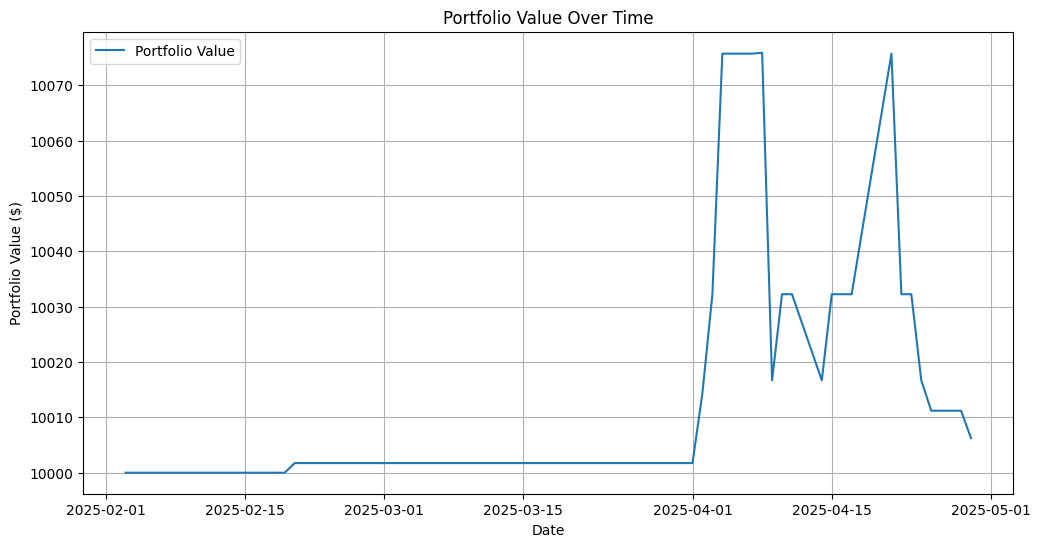

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(results["portfolio_value"], label="Portfolio Value" )
plt.title("Portfolio Value Over Time")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)
plt.legend()

plt.savefig("../portfolio_value_plot.png")
plt.show()


In [8]:
roi = (results['portfolio_value'].iloc[-1] - initial_cash) / initial_cash
returns = results['portfolio_value'].pct_change().dropna()
sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(252)

# Accuracy
correct_trades = 0
total_trades = 0
for i in range(1, len(results)):
    if results["signal"].iloc[i-1] == "buy" and results["signal"].iloc[i] == "sell":
        entry = results["price"].iloc[i-1]
        exit_ = results["price"].iloc[i]
        if exit_ > entry:
            correct_trades += 1
        total_trades += 1

accuracy = correct_trades / total_trades if total_trades > 0 else None

print(f"🔁 ROI: {(roi*100):.2%}")
print(f"📈 Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"✅ Trade Accuracy: {accuracy:.2%}" if accuracy is not None else "No buy→sell trades to evaluate.")


🔁 ROI: 6.25%
📈 Sharpe Ratio: 0.14
✅ Trade Accuracy: 100.00%


In [7]:
results.signal.value_counts()

signal
sell    39
buy     21
Name: count, dtype: int64